In [1]:
import pandas as pd
from scipy.io import arff
import numpy as np
import matplotlib.pyplot as plt
#import phik
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
import graphviz

from google.colab import files
uploaded = files.upload()

data_file="german_credit.arff"
# If using other datasets then comment the above line and uncomment one of the following two lines
#data_file="bank.arff"
#data_file="churn.arff"
data=arff.loadarff(data_file)

df=pd.DataFrame(data[0])
for col in df.columns:
  if df[col].dtype=='object':
    #making sure data is not read as bytes but as string values from a file
    df[col] = df[col].str.decode('utf-8')
#Look at loaded data and data types
#print(df.dtypes)

# Human friendly labels for Creditability
CredLabelDict = { "0":"Bad(0)","1":"Good(1)"}
def CredLabels(creds):
    reslabels = []
    for cred in creds:
        #print(type(cred),str(type(cred)))
        if str(type(cred))=="<class 'matplotlib.text.Text'>":
            cred = cred.get_text()
        reslabels.append(CredLabelDict[cred])
    if len(reslabels)==1:
        reslabels = reslabels[0]
    return reslabels

Saving german_credit.arff to german_credit (1).arff


In [2]:
# Let's display first 10 records 
df.head(10)


,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,Guarantors,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18.0,4,2,1049.0,1,2,4.0,2,1,4,2,21.0,3,1,1.0,3,1.0,1,1
1,1,1,9.0,4,0,2799.0,1,3,2.0,3,1,2,1,36.0,3,1,2.0,3,2.0,1,1
2,1,2,12.0,2,9,841.0,2,4,2.0,2,1,4,1,23.0,3,1,1.0,2,1.0,1,1
3,1,1,12.0,4,0,2122.0,1,3,3.0,3,1,2,1,39.0,3,1,2.0,2,2.0,1,2
4,1,1,12.0,4,0,2171.0,1,3,4.0,3,1,4,2,38.0,1,2,2.0,2,1.0,1,2
5,1,1,10.0,4,0,2241.0,1,2,1.0,3,1,3,1,48.0,3,1,2.0,2,2.0,1,2
6,1,1,8.0,4,0,3398.0,1,4,1.0,3,1,4,1,39.0,3,2,2.0,2,1.0,1,2
7,1,1,6.0,4,0,1361.0,1,2,2.0,3,1,4,1,40.0,3,2,1.0,2,2.0,1,2
8,1,4,18.0,4,3,1098.0,1,1,4.0,2,1,4,3,65.0,3,2,2.0,1,1.0,1,1
9,1,2,24.0,2,3,3758.0,3,1,1.0,2,1,4,4,23.0,3,1,1.0,1,1.0,1,1


In [3]:
# look at meta information about data, such as null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Creditability                      1000 non-null   object 
 1   Account Balance                    1000 non-null   object 
 2   Duration of Credit (month)         1000 non-null   float64
 3   Payment Status of Previous Credit  1000 non-null   object 
 4   Purpose                            1000 non-null   object 
 5   Credit Amount                      1000 non-null   float64
 6   Value Savings/Stocks               1000 non-null   object 
 7   Length of current employment       1000 non-null   object 
 8   Instalment per cent                1000 non-null   float64
 9   Sex & Marital Status               1000 non-null   object 
 10  Guarantors                         1000 non-null   object 
 11  Duration in Current address        1000 non-null   object

In [4]:
df.describe(include='all')

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,Guarantors,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
count,1000,1000,1000.000000,1000,1000,1000.00000,1000,1000,1000.000000,1000,1000,1000,1000,1000.00000,1000,1000,1000.000000,1000,1000.000000,1000,1000
unique,2,4,NaN,5,10,NaN,5,5,NaN,4,3,4,4,NaN,3,3,NaN,4,NaN,2,2
top,1,4,NaN,2,3,NaN,1,3,NaN,3,1,4,3,NaN,3,2,NaN,3,NaN,1,1
freq,700,394,NaN,530,280,NaN,603,339,NaN,548,907,413,332,NaN,814,714,NaN,630,NaN,596,963
mean,NaN,NaN,20.903000,NaN,NaN,3271.24800,NaN,NaN,2.973000,NaN,NaN,NaN,NaN,35.54200,NaN,NaN,1.407000,NaN,1.155000,NaN,NaN
std,NaN,NaN,12.058814,NaN,NaN,2822.75176,NaN,NaN,1.118715,NaN,NaN,NaN,NaN,11.35267,NaN,NaN,0.577654,NaN,0.362086,NaN,NaN
min,NaN,NaN,4.000000,NaN,NaN,250.00000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,19.00000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN
25%,NaN,NaN,12.000000,NaN,NaN,1365.50000,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,27.00000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN
50%,NaN,NaN,18.000000,NaN,NaN,2319.50000,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,33.00000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN
75%,NaN,NaN,24.000000,NaN,NaN,3972.25000,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,42.00000,NaN,NaN,2.000000,NaN,1.000000,NaN,NaN


## Section 1 Exploratory Analysis


In [5]:
import sys
!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

Requirement already up-to-date: pandas-profiling[notebook] in /usr/local/lib/python3.7/dist-packages (3.0.0)
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [6]:
import pandas_profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(df, correlations={
        "pearson": {"calculate": False},
        "spearman": {"calculate": False},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": True},
        "cramers": {"calculate": False},
    },html={"inline": True})

In [ ]:
#profile.to_widgets()

In [ ]:
#profile.to_notebook_iframe()
#profile.to_file("profile_report.html")

In [7]:
# correct type for a couple of numerical columns:
df["No of Credits at this Bank"] = df["No of Credits at this Bank"].astype('int64')
df["No of dependents"] = df["No of dependents"].astype('int64')
df["Instalment per cent"] = df["Instalment per cent"].astype('int64')
#df["No of dependents"] = df["No of dependents"].astype('category')
df["Duration of Credit (month)"] = df["Duration of Credit (month)"].astype('int64')
# Purpose converted to int to allow sorting the labels
df["Purpose"] = df["Purpose"].astype('int64')
df.dtypes

Creditability                         object
Account Balance                       object
Duration of Credit (month)             int64
Payment Status of Previous Credit     object
Purpose                                int64
Credit Amount                        float64
Value Savings/Stocks                  object
Length of current employment          object
Instalment per cent                    int64
Sex & Marital Status                  object
Guarantors                            object
Duration in Current address           object
Most valuable available asset         object
Age (years)                          float64
Concurrent Credits                    object
Type of apartment                     object
No of Credits at this Bank             int64
Occupation                            object
No of dependents                       int64
Telephone                             object
Foreign Worker                        object
dtype: object

In [8]:
df[df.columns[df.columns != "Purpose"]].describe()

,Duration of Credit (month),Credit Amount,Instalment per cent,Age (years),No of Credits at this Bank,No of dependents
count,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000
mean,20.903000,3271.24800,2.973000,35.54200,1.407000,1.155000
std,12.058814,2822.75176,1.118715,11.35267,0.577654,0.362086
min,4.000000,250.00000,1.000000,19.00000,1.000000,1.000000
25%,12.000000,1365.50000,2.000000,27.00000,1.000000,1.000000
50%,18.000000,2319.50000,3.000000,33.00000,1.000000,1.000000
75%,24.000000,3972.25000,4.000000,42.00000,2.000000,1.000000
max,72.000000,18424.00000,4.000000,75.00000,4.000000,2.000000


In [9]:
from matplotlib.ticker import FormatStrFormatter

def HistogramOnCred(df, mycol, ax, log = False):
    tempdf = df[["Creditability",mycol]].copy()
    if (df[mycol].dtype.name == "float64") or (len(df[mycol].unique()) >= 20):
        # For numerical variables
        nbins = 10
        myrange = (tempdf[mycol].min(),tempdf[mycol].max())
        hist0 = np.histogram(tempdf.groupby(by="Creditability", axis=0).get_group("0")[mycol],range=myrange,bins=nbins)
        hist1 = np.histogram(tempdf.groupby(by="Creditability", axis=0).get_group("1")[mycol],range=myrange,bins=nbins)
        ax.bar(hist0[1][1:], hist0[0], width=(hist0[1][1]-hist0[1][0])/2, align='center', log = log, label=CredLabels("0"))
        ax.bar(hist0[1][1:]-(hist0[1][1]-hist0[1][0])/2, hist1[0], width=(hist0[1][1]-hist0[1][0])/2, align='center', log = log, label=CredLabels("1"))
        ax1 = ax.twinx()
        tempdf.groupby(by="Creditability", axis=0).get_group("0")[mycol].plot.density(ax=ax1, label = "Density " +  CredLabels("0") + " Cred.")
        tempdf.groupby(by="Creditability", axis=0).get_group("1")[mycol].plot.density(ax=ax1, label = "Density " +  CredLabels("1") + " Cred.")
        ax.legend(title="Creditability")
        #ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax1.legend(loc='right')
        ax.set_xlim(left=0)
        ax1.set_ylabel("Density")
        ax.set_xlabel(mycol)
        ax.set_ylabel("Occurences")
    else:
        # For categorical
        tempdf = df[["Creditability",mycol]].copy()
        # dummy column
        tempdf["Occurrences"] = 1
        totals = tempdf.groupby(by=[mycol,"Creditability"]).count().unstack(level=-1)["Occurrences"]
        totals.columns = CredLabels(totals.columns)
        totals.plot.bar(rot=0,ax=ax)
        ax.set_xlabel(mycol)
        ax.set_ylabel("Occurences")
        ax.legend(title="Creditability")




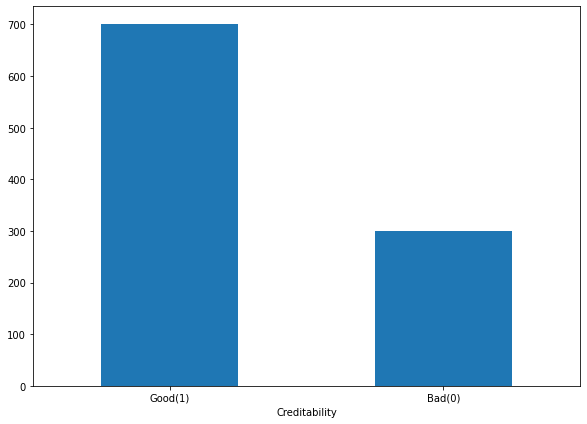

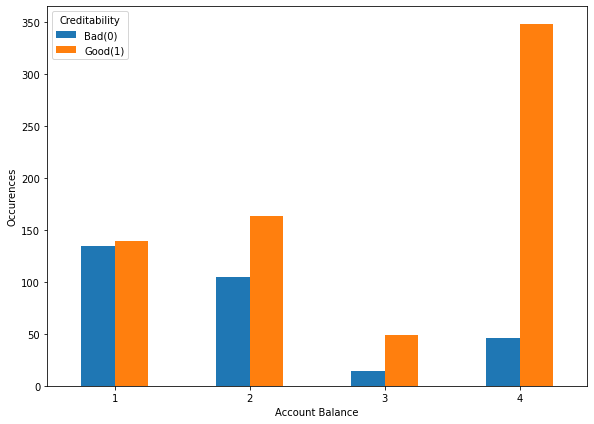

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


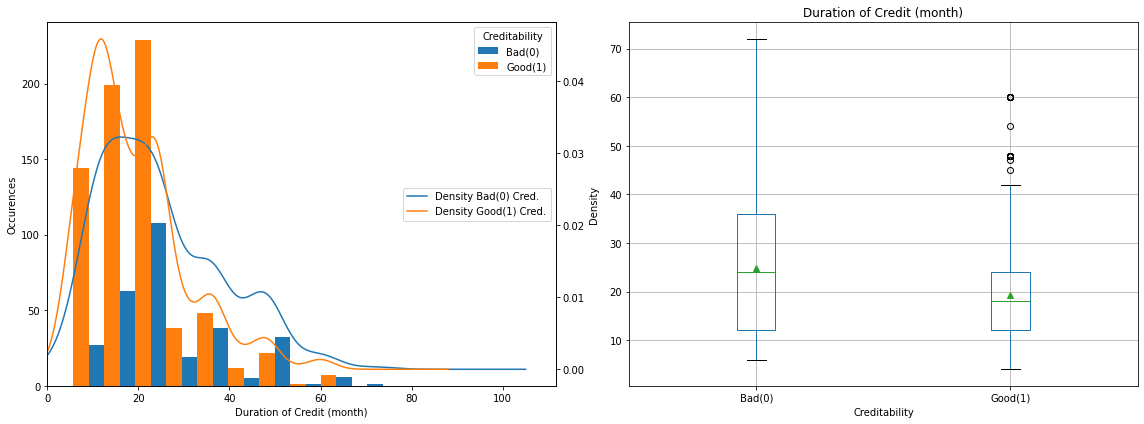

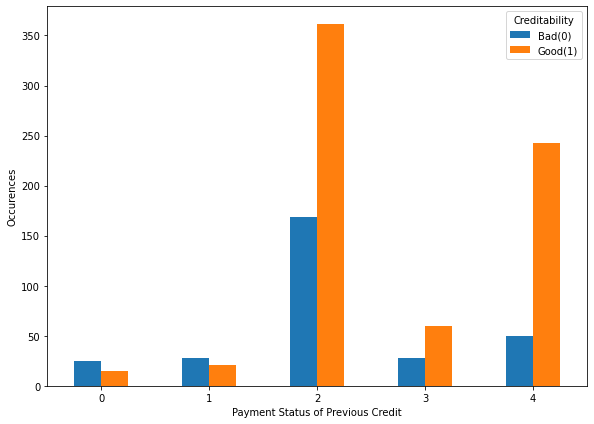

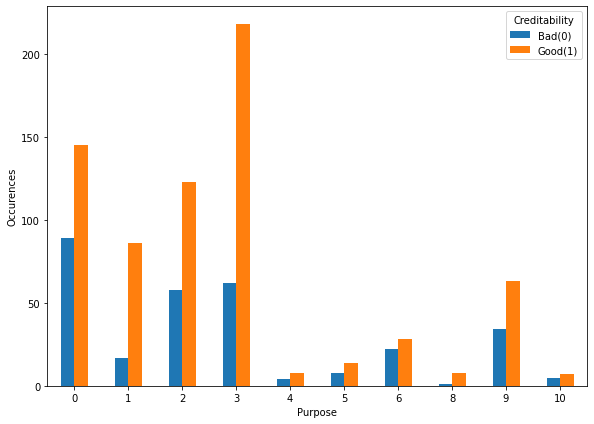

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


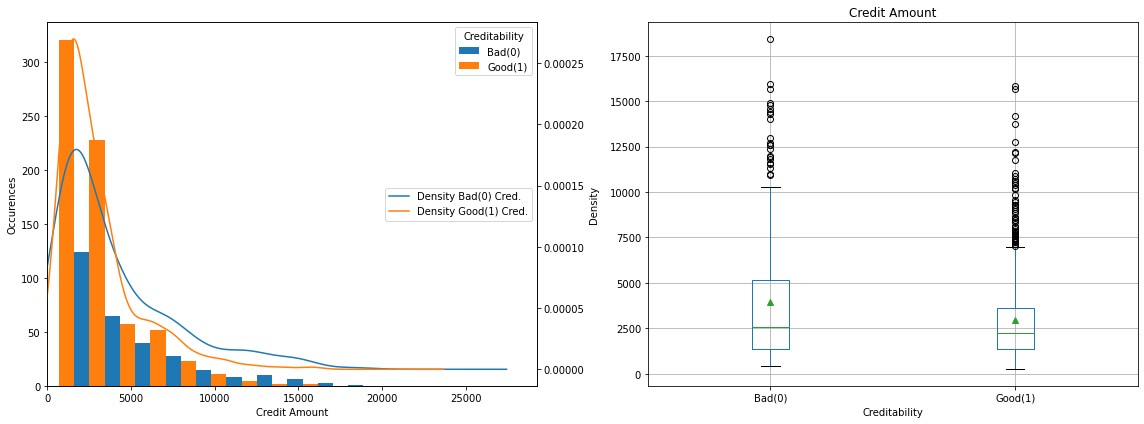

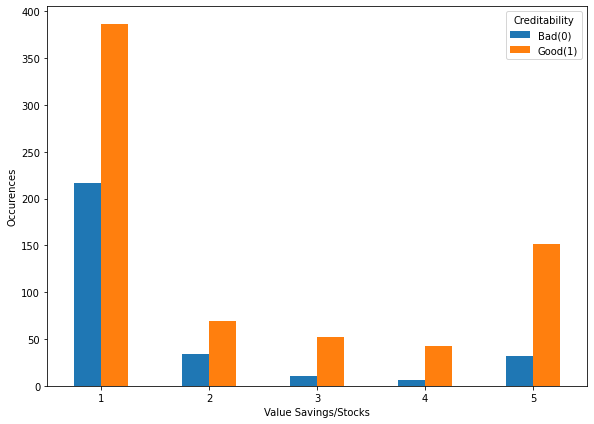

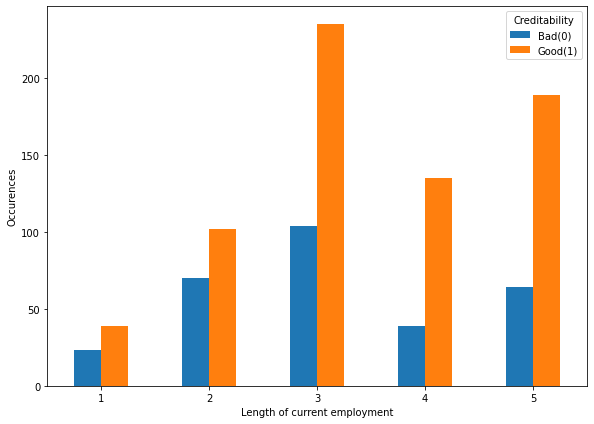

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


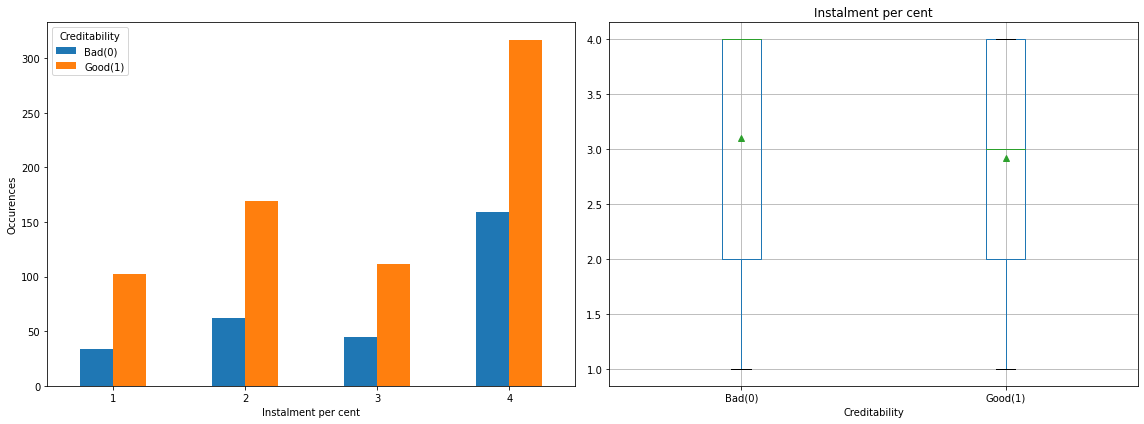

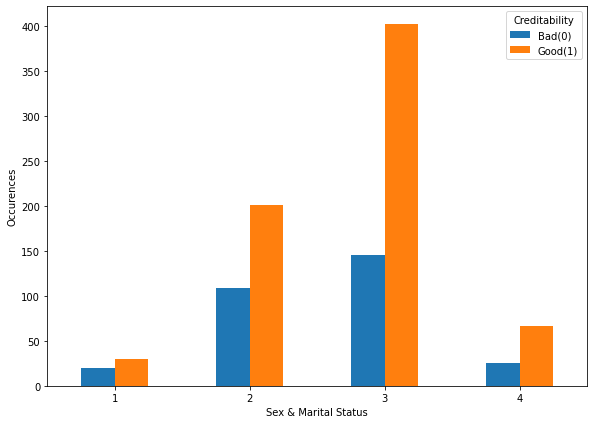

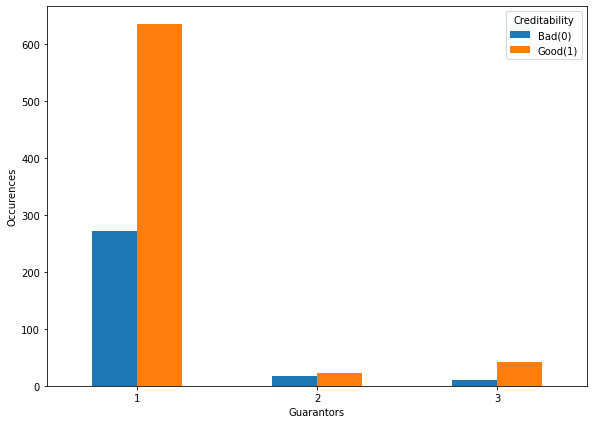

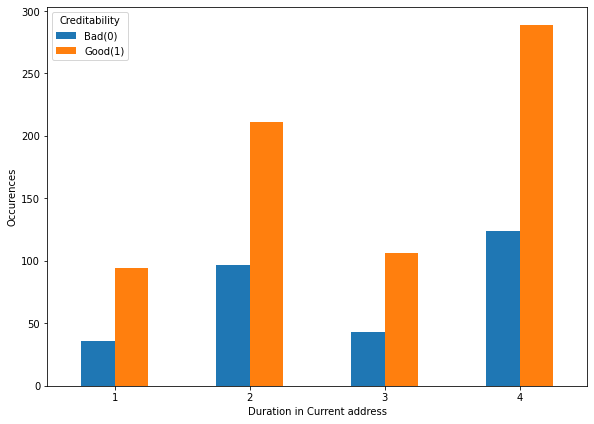

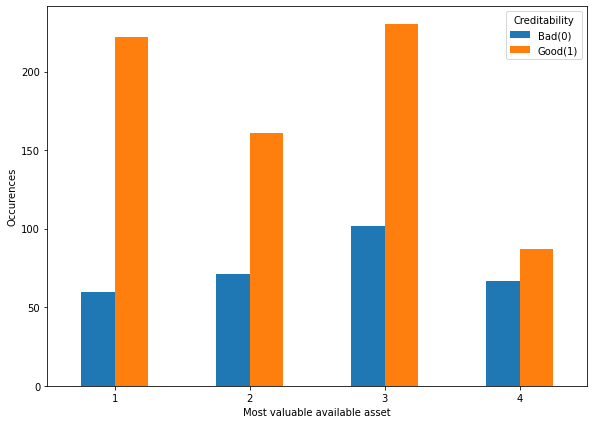

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


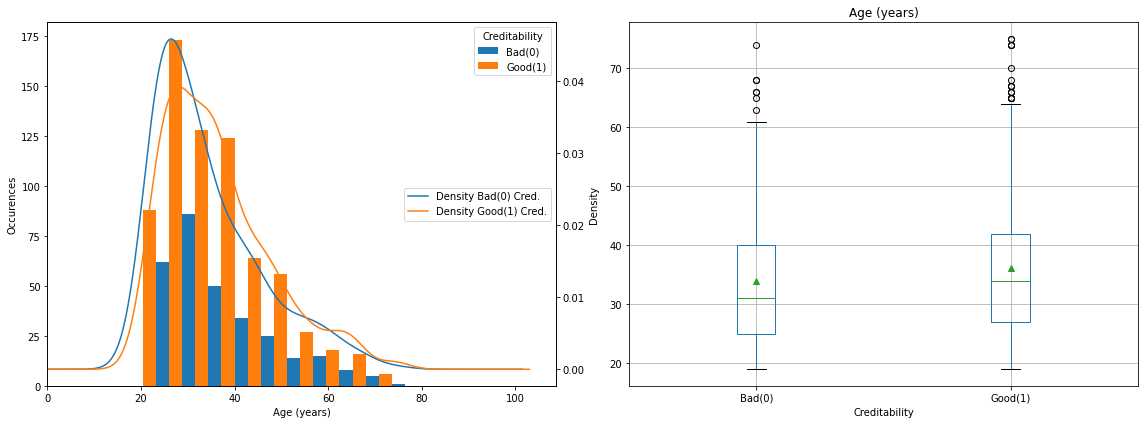

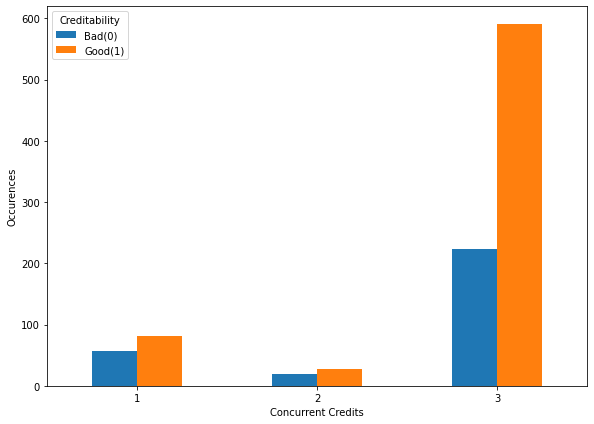

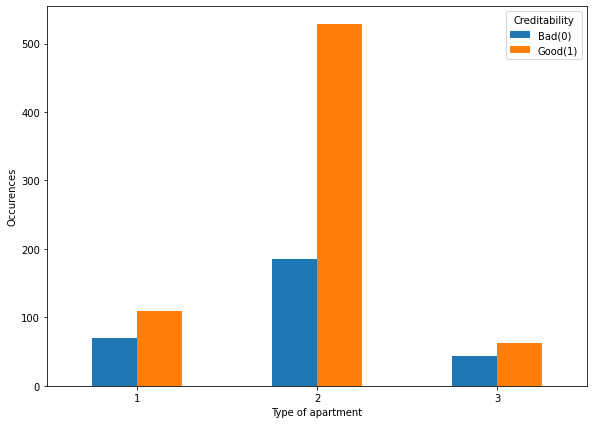

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


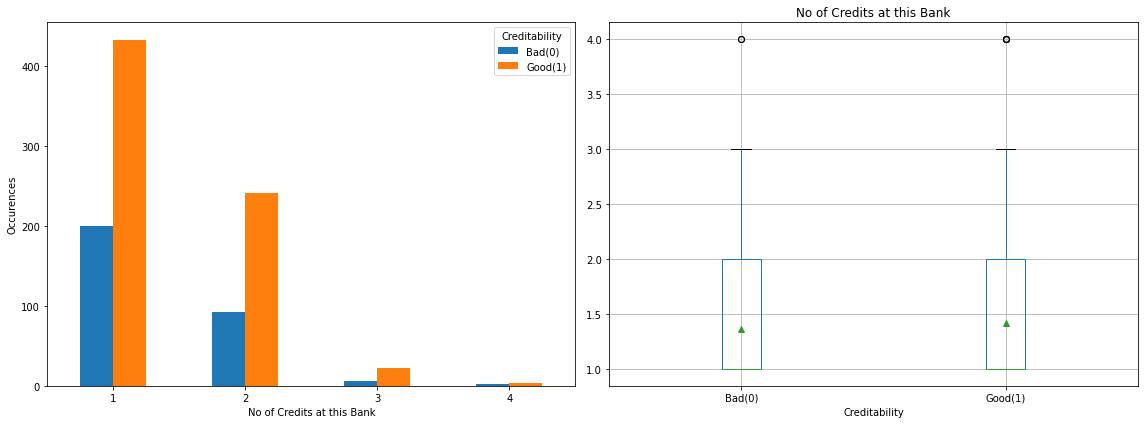

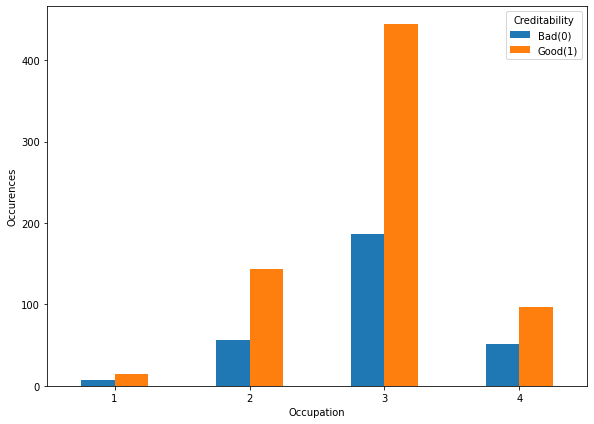

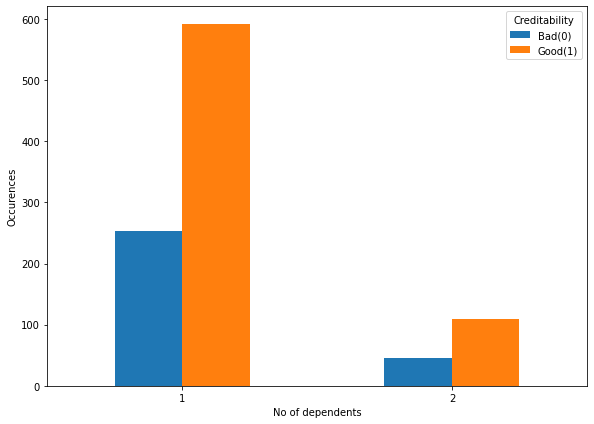

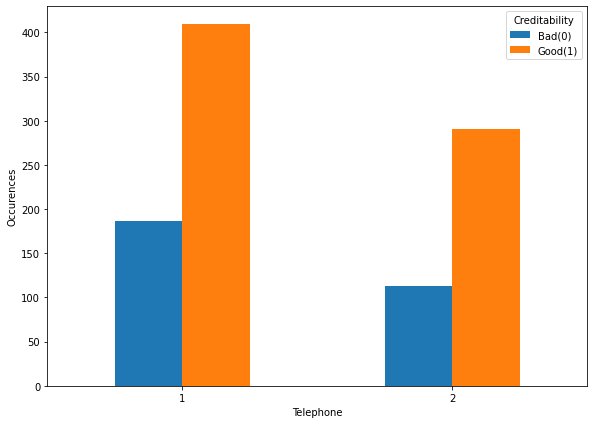

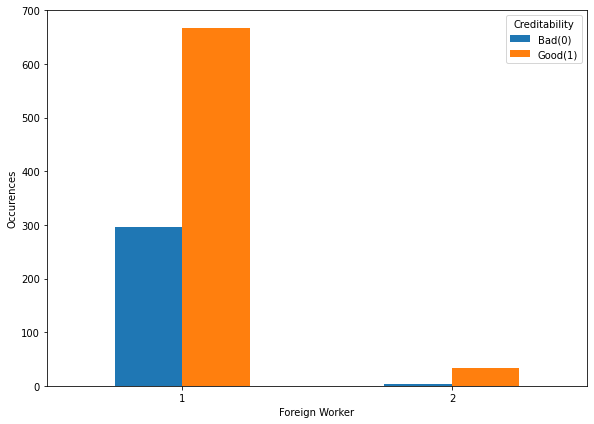

['Creditability',
 'Account Balance',
 'Payment Status of Previous Credit',
 'Purpose',
 'Value Savings/Stocks',
 'Length of current employment',
 'Sex & Marital Status',
 'Guarantors',
 'Duration in Current address',
 'Most valuable available asset',
 'Concurrent Credits',
 'Type of apartment',
 'Occupation',
 'No of dependents',
 'Telephone',
 'Foreign Worker']

In [10]:
# identify categorical columns (not really needed)
catcols = []
#for mycol in list(df.columns[(df.dtypes == np.float64) | (df.dtypes == np.int64) |(df.dtypes == "category")]):
for mycol in df.columns:
    #print(mycol)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    #fig.subplots_adjust(wspace=1.5)
    #fig.figsize = (10,10)
    ###fig.suptitle(mycol, x = 0.2, ha = "left", fontsize = "x-large")
    #print(df[mycol].dtype.name)
    #print(type(df[mycol].dtypes))
    if (df[mycol].dtype.name == "float64"):
        df.boxplot(column=mycol, by="Creditability",showmeans=True, ax=axes[1])
        # use more readable labels for Creditability
        axes[1].set_xticklabels(CredLabels(axes[1].get_xticklabels()))
        # bar plot
        HistogramOnCred(df, mycol, ax=axes[0])
    elif (df[mycol].dtype.name != "category"):
        if (len(df[mycol].unique()) < 20) and (mycol not in ["Instalment per cent","No of Credits at this Bank"]):
            axes[1].set_visible(False)
            if (mycol == "Creditability"):
                df[mycol].value_counts(sort=True).plot.bar(rot=0, ax=axes[0])
                axes[0].set_xticklabels(CredLabels(axes[0].get_xticklabels()))
                axes[0].set_xlabel(mycol)
            else:
                #df[mycol].value_counts(sort=True).plot.bar(rot=0, ax=axes[0])
                # For categorical
                HistogramOnCred(df, mycol, ax=axes[0])
            catcols.append(mycol)
        else:
            df.boxplot(column=mycol,by="Creditability", showmeans=True, ax=axes[1], figsize=(5,10))
            axes[1].set_xticklabels(CredLabels(axes[1].get_xticklabels()))
            #df.hist(column=mycol,ax=axes[0], figsize=(5,10))
            HistogramOnCred(df, mycol, ax=axes[0])
    else:
        axes[1].set_visible(False)
        #df[mycol].value_counts(sort=False).plot.bar(rot=0, ax=axes[0])
        HistogramOnCred(df, mycol, ax=axes[0])
        catcols.append(mycol)
    #axes[0].set_xlabel(mycol)
    #df.hist(column=mycol,ax=axes[1], figsize=(5,10), bins=len(df[mycol].unique()))
    fig.suptitle("")
    fig.tight_layout()
    plt.show()
    
catcols


In [11]:
import phik
df.phik_matrix()["Creditability"].sort_values(ascending=False)

interval columns not set, guessing: ['Duration of Credit (month)', 'Purpose', 'Credit Amount', 'Instalment per cent', 'Age (years)', 'No of Credits at this Bank', 'No of dependents']


Creditability                        1.000000
Account Balance                      0.512074
Duration of Credit (month)           0.285273
Credit Amount                        0.240898
Most valuable available asset        0.217130
Payment Status of Previous Credit    0.196876
Purpose                              0.152796
Age (years)                          0.151983
Value Savings/Stocks                 0.146780
Sex & Marital Status                 0.122863
Foreign Worker                       0.108911
Length of current employment         0.098172
Type of apartment                    0.077969
Instalment per cent                  0.075278
Concurrent Credits                   0.062824
Guarantors                           0.041100
Telephone                            0.020644
Duration in Current address          0.000000
No of Credits at this Bank           0.000000
Occupation                           0.000000
No of dependents                     0.000000
Name: Creditability, dtype: float6

interval columns not set, guessing: ['Duration of Credit (month)', 'Purpose', 'Credit Amount', 'Instalment per cent', 'Age (years)', 'No of Credits at this Bank', 'No of dependents']


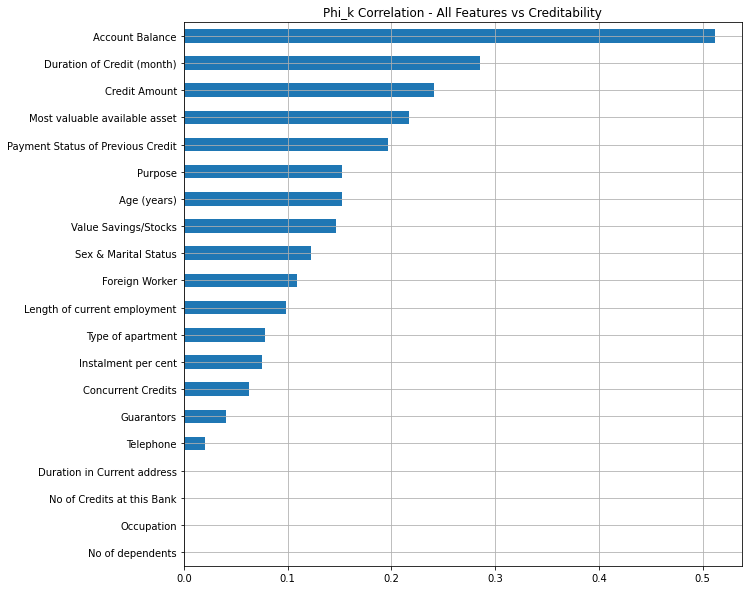

In [12]:
#featurecorr = df.phik_matrix()["Creditability"].sort_values(ascending=False)[1:]
#featurecorr = df.phik_matrix()["Creditability"].sort_values()[:-1]
featurecorr = df.phik_matrix()["Creditability"]
featurecorr.sort_values()[:-1].plot.barh(figsize=(10,10),title = "Phi_k Correlation - All Features vs Creditability",grid=True)

In [11]:
# Select a minimun number of features based on correlation
minfeatures = ["Creditability","Duration of Credit (month)","Credit Amount"]

In [13]:
# Feature Importance >= 0.1
CART_features =  ["Creditability","Duration of Credit (month)","Credit Amount","Age (years)"]

In [14]:
# features with a "high" correlation
features_high_corr = list(featurecorr[featurecorr > 0.1].index)
#features_high_corr.insert(0,"Creditability")
features_high_corr

['Creditability',
 'Account Balance',
 'Duration of Credit (month)',
 'Payment Status of Previous Credit',
 'Purpose',
 'Credit Amount',
 'Value Savings/Stocks',
 'Sex & Marital Status',
 'Most valuable available asset',
 'Age (years)',
 'Foreign Worker']

In [15]:
# function to get the thresholds for the outliers
# from https://codefires.com/how-to-remove-outliers-in-python-pandas-package/
def outliers(df, feature):
    Q1= df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit


In [16]:
# Generate a Data Set eliminating outliers for
# Age, Credit Ammount, Duration of Credit
FeatureWithOutliers = ['Duration of Credit (month)','Credit Amount','Age (years)']
df_nooutliers = None
for feat in FeatureWithOutliers:
    upper = {} 
    lower = {}
    for cred in ["0","1"]:
        upper[cred], lower[cred] = outliers(df[df["Creditability"]==cred], feat)
        print(cred,feat,lower,upper)
    if df_nooutliers is None:
        df_nooutliers =  df[ \
                            ((df[feat] >= lower["0"]) & (df[feat] <= upper["0"]) & (df["Creditability"]=="0")) | \
                            ((df[feat] >= lower["1"]) & (df[feat] <= upper["1"]) & (df["Creditability"]=="1")) \
                           ].copy()
    else:
        df_nooutliers = df_nooutliers[ \
                                      ((df_nooutliers[feat] >= lower["0"]) & (df_nooutliers[feat] <= upper["0"]) & (df_nooutliers["Creditability"]=="0")) | \
                                      ((df_nooutliers[feat] >= lower["1"]) & (df_nooutliers[feat] <= upper["1"]) & (df_nooutliers["Creditability"]=="1")) \
                                     ].copy()
df_nooutliers     

0 Duration of Credit (month) {'0': -24.0} {'0': 72.0}
1 Duration of Credit (month) {'0': -24.0, '1': -6.0} {'0': 72.0, '1': 42.0}
0 Credit Amount {'0': -4331.0} {'0': 10825.0}
1 Credit Amount {'0': -4331.0, '1': -2013.375} {'0': 10825.0, '1': 7023.625}
0 Age (years) {'0': 2.5} {'0': 62.5}
1 Age (years) {'0': 2.5, '1': 4.5} {'0': 62.5, '1': 64.5}


,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,Guarantors,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049.0,1,2,4,2,1,4,2,21.0,3,1,1,3,1,1,1
1,1,1,9,4,0,2799.0,1,3,2,3,1,2,1,36.0,3,1,2,3,2,1,1
2,1,2,12,2,9,841.0,2,4,2,2,1,4,1,23.0,3,1,1,2,1,1,1
3,1,1,12,4,0,2122.0,1,3,3,3,1,2,1,39.0,3,1,2,2,2,1,2
4,1,1,12,4,0,2171.0,1,3,4,3,1,4,2,38.0,1,2,2,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0,1,12,0,3,6199.0,1,3,4,3,1,2,2,28.0,3,1,2,3,1,2,1
995,0,1,24,2,3,1987.0,1,3,2,3,1,4,1,21.0,3,1,1,2,2,1,1
996,0,1,24,2,0,2303.0,1,5,4,3,2,1,1,45.0,3,2,1,3,1,1,1
998,0,2,12,2,3,6468.0,5,1,2,3,1,1,4,52.0,3,2,1,4,1,2,1


In [17]:
# Remove outliers but wihtout taking "Creditability" into account
# Generate a Data Set eliminating outliers for
# Age, Credit Ammount, Duration of Credit
#FeatureWithOutliers = ['Duration of Credit (month)','Credit Amount','Age (years)']
#df_nooutliers = None
#for feat in FeatureWithOutliers:
#        upper, lower = outliers(df, feat)
#        print(feat,lower,upper)
#        if df_nooutliers is None:
#            df_nooutliers =  df[(df[feat] >= lower) & (df[feat] <= upper) ].copy()
#        else:
#            df_nooutliers = df_nooutliers[(df_nooutliers[feat] >= lower) & (df_nooutliers[feat] <= upper) ].copy()
#df_nooutliers     

In [18]:
# generate 4 datasets
# original-all_features - all features, all data points
# original-min_features - minimun number of features, all data points
# original-high_corr_feat - "highly correlated" features, all data points
# nooutliers-all_features - all features, outliers removed
dff = {}
#dff["original-all_features"] = df.copy()
#dff["original-min_features"] = df[minfeatures].copy()
#dff["original-high_corr_feat"] = df[features_high_corr].copy()
dff["TEST_1_all_features"] = df.copy()
#dff["min_features"] = df[minfeatures].copy()
dff["TEST_2_importance-CART_features"] = df[CART_features].copy()
dff["TEST_3_high_corr_feat"] = df[features_high_corr].copy()
# Do not test removing outliers
#dff["nooutliers-all_features"] = df_nooutliers.copy()



# Section 2: Multiple Tests with One-Hot (numeric) Encoding 


In [24]:
#Let's create a list for our categorical columns for German dataset, we need this later
# for German Credit card
cat_cols=["Account Balance","Payment Status of Previous Credit","Purpose","Value Savings/Stocks","Length of current employment","Sex & Marital Status"\
          ,"Guarantors","Duration in Current address","Most valuable available asset","Concurrent Credits","Type of apartment","Occupation", \
          "Telephone","Foreign Worker"]

In [32]:
from sklearn.naive_bayes import ComplementNB

def MyNaiveBayes(X_train, X_test, y_train, y_test, usegini = True):
    #Create a MultiNomial NB Classifier
    nb = ComplementNB()

    #Train the model using the training sets
    nb.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = nb.predict(X_test)
    print ("Succesfully done..")
    
    print("Number of features used ",nb.n_features_)
    print("Classes ",nb.classes_)
    print("Number of records for classes ",nb.class_count_)
    print("Log prior probability for classes ", nb.class_log_prior_)
    #print("Log conditional probability for each feature given a class\n",nb.feature_log_prob_)
    
    cf=confusion_matrix(y_test, y_pred)
    #confmat[testname] = cf
    #print ("Confusion Matrix")
    #print(cf)
    tn, fp, fn, tp=cf.ravel()
    #print ("TP: ", tp,", FP: ", fp,", TN: ", tn,", FN:", fn)
    cfdict = {"TP": tp , "FP": fp, "TN": tn, "FN": fn}
    
    cr = classification_report(y_test, y_pred, output_dict=True)

    # use a reformatted dictionary for easier handling later
    crselected = {}
    crselected["precision(0)"] = round(cr['0']['precision'],2)
    crselected["precision(1)"] = round(cr['1']['precision'],2)
    crselected["recall(0)"] = round(cr['0']['recall'],2)
    crselected["recall(1)"] = round(cr['1']['recall'],2)
    crselected["f1-score(0)"] = round(cr['0']['f1-score'],2)
    crselected["f1-score(1)"] = round(cr['1']['f1-score'],2)
    crselected["accuracy"] = round(cr['accuracy'],2)

    #print(crselected)
    
    return (cfdict, crselected)

In [63]:
def MyDT(X_train, X_test, y_train, y_test, max_depth = None):
    # clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf = tree.DecisionTreeClassifier(max_depth=max_depth, ccp_alpha=0.013)
    #clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
   
    #Get unique class values to display on the tree
    class_values=df_onehot[class_col_name].unique()
    #print ("class Names",class_values)

    dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=one_hot_feature_names,  
                                class_names=class_values,
                                filled=True)

    # Draw graph
    graph = graphviz.Source(dot_data, format="png")
    
    # Perform prediction on the test set
    y_pred = clf.predict(X_test)
    
    cf=confusion_matrix(y_test, y_pred)

    #print ("Confusion Matrix")
    #print(cf)
    tn, fp, fn, tp=cf.ravel()
    #print ("TP: ", tp,", FP: ", fp,", TN: ", tn,", FN:", fn)
    cfdict = {"TP": tp , "FP": fp, "TN": tn, "FN": fn}

    cr = classification_report(y_test, y_pred, output_dict=True)
    
    # use a reformatted dictionary for easier handling later
    crselected = {}
    crselected["precision(0)"] = round(cr['0']['precision'],2)
    crselected["precision(1)"] = round(cr['1']['precision'],2)
    crselected["recall(0)"] = round(cr['0']['recall'],2)
    crselected["recall(1)"] = round(cr['1']['recall'],2)
    crselected["f1-score(0)"] = round(cr['0']['f1-score'],2)
    crselected["f1-score(1)"] = round(cr['1']['f1-score'],2)
    crselected["accuracy"] = round(cr['accuracy'],2)

    #importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(clf.feature_importances_,2)})
    #importances = importances.sort_values('importance',ascending=False)

    #print(crselected)
    
    return(cfdict,crselected, graph)

In [64]:
# store results for each case
graphs = {}
# confusion matrix for each case
confmat = {}
# classification metrics for each case
classmet = {}

for i, dframe in dff.items():
    
    #convert only categorical variables/features to dummy/one-hot features
    my_cat_cols = [x for x in cat_cols if x in dframe.columns]
    # get all feature names
    class_col_name="Creditability"        
    # Create a copy of the data frame in memory with a different name
    df_onehot=dframe.copy()
    # convert categorical columns to dummy
    df_onehot = pd.get_dummies(dframe, columns=my_cat_cols, prefix = my_cat_cols)
    one_hot_feature_names=df_onehot.columns[df_onehot.columns != class_col_name]
    # Split dataset into training set and test set
    # 70% training and 30% test
    X_train, X_test, y_train, y_test = train_test_split(df_onehot.loc[:, one_hot_feature_names], df_onehot[class_col_name], test_size=0.3,random_state=109)
       
    numfeatures = len(df_onehot.columns) - 1

    #print the dataset
    print("==========================================================")
    print("Iteration:",i,"Number of Features:", numfeatures)
    print()
    

    # Test 1 - Bayes
    # testname = "Feat:" + str(numfeatures) + " Bayes"
    # testname = i + " Bayes"
    # print ("Test '", testname, "' *****************")   
    
    # (cf,cr) = MyNaiveBayes(X_train, X_test, y_train, y_test)
    # confmat[testname] = cf
    # classmet[testname] = cr
    # print(cf)
    # print(cr)
    # print()
    
    # Test 2 - Decision Tree depth = 5
    testname = i + " DT depth:5"
    print ("Test '", testname, "' *****************")   
    
    (cf,cr,graph) = MyDT(X_train, X_test, y_train, y_test, max_depth = 5)
    confmat[testname] = cf
    classmet[testname] = cr
    graphs[testname] = graph
    print(cf)
    print(cr)
    print()
    
    # Test 3 - Decision Tree No max depth
    testname = i + " DT depth:no limit"
    print ("Test '", testname, "' *****************")   
    
    (cf,cr,graph) = MyDT(X_train, X_test, y_train, y_test, max_depth = None)
    confmat[testname] = cf
    classmet[testname] = cr
    graphs[testname] = graph
    print(cf)
    print(cr)
    print()

Iteration: TEST_1_all_features Number of Features: 64

Test ' TEST_1_all_features DT depth:5 ' *****************
{'TP': 205, 'FP': 95, 'TN': 0, 'FN': 0}
{'precision(0)': 0.0, 'precision(1)': 0.68, 'recall(0)': 0.0, 'recall(1)': 1.0, 'f1-score(0)': 0.0, 'f1-score(1)': 0.81, 'accuracy': 0.68}

Test ' TEST_1_all_features DT depth:no limit ' *****************
{'TP': 205, 'FP': 95, 'TN': 0, 'FN': 0}
{'precision(0)': 0.0, 'precision(1)': 0.68, 'recall(0)': 0.0, 'recall(1)': 1.0, 'f1-score(0)': 0.0, 'f1-score(1)': 0.81, 'accuracy': 0.68}

Iteration: TEST_2_importance-CART_features Number of Features: 3

Test ' TEST_2_importance-CART_features DT depth:5 ' *****************
{'TP': 205, 'FP': 95, 'TN': 0, 'FN': 0}
{'precision(0)': 0.0, 'precision(1)': 0.68, 'recall(0)': 0.0, 'recall(1)': 1.0, 'f1-score(0)': 0.0, 'f1-score(1)': 0.81, 'accuracy': 0.68}

Test ' TEST_2_importance-CART_features DT depth:no limit ' *****************
{'TP': 205, 'FP': 95, 'TN': 0, 'FN': 0}
{'precision(0)': 0.0, 'precis

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [65]:
TestResults = pd.DataFrame.from_dict(confmat, orient='index').merge(pd.DataFrame.from_dict(classmet, orient='index'),left_index=True, right_index=True)
# acc column for total of true detections
#TestResults["TrueTotals"] = (TestResults["TP"] + TestResults["TN"])/TestResults[["TP","TN","FP","FN"]].sum(axis=1)
TestResults["risk"] = round(TestResults["FP"]/TestResults[["TP","TN","FP","FN"]].sum(axis=1),2)
TestResults = TestResults.sort_values(by="accuracy").copy()


TestResults

#TestResults = TestResults[TestResults[0].str.contains('DT')].copy()

#df[df['ids'].str.contains("ball")]
#orders[orders['PromoID'] == '30_OFF']

,TP,FP,TN,FN,precision(0),precision(1),recall(0),recall(1),f1-score(0),f1-score(1),accuracy,risk
TEST_1_all_features DT depth:5,205,95,0,0,0.0,0.68,0.0,1.0,0.0,0.81,0.68,0.32
TEST_1_all_features DT depth:no limit,205,95,0,0,0.0,0.68,0.0,1.0,0.0,0.81,0.68,0.32
TEST_2_importance-CART_features DT depth:5,205,95,0,0,0.0,0.68,0.0,1.0,0.0,0.81,0.68,0.32
TEST_2_importance-CART_features DT depth:no limit,205,95,0,0,0.0,0.68,0.0,1.0,0.0,0.81,0.68,0.32
TEST_3_high_corr_feat DT depth:5,205,95,0,0,0.0,0.68,0.0,1.0,0.0,0.81,0.68,0.32
TEST_3_high_corr_feat DT depth:no limit,205,95,0,0,0.0,0.68,0.0,1.0,0.0,0.81,0.68,0.32


In [ ]:
print(TestResults.columns)

Index(['TP', 'FP', 'TN', 'FN', 'precision(0)', 'precision(1)', 'recall(0)',
       'recall(1)', 'f1-score(0)', 'f1-score(1)', 'accuracy', 'risk'],
      dtype='object')


[0.68, 0.67, 0.72, 0.7, 0.69, 0.7, 0.7, 0.68, 0.67, 0.69]
                                feature  importance
1                         Credit Amount        0.20
2                           Age (years)        0.15
6                     Account Balance_4        0.13
0            Duration of Credit (month)        0.11
22               Value Savings/Stocks_1        0.05
11  Payment Status of Previous Credit_4        0.04
23               Value Savings/Stocks_2        0.03
13                            Purpose_1        0.03
17                            Purpose_5        0.02
26               Value Savings/Stocks_5        0.02
12                            Purpose_0        0.02
20                            Purpose_9        0.02
9   Payment Status of Previous Credit_2        0.02
8   Payment Status of Previous Credit_1        0.02
32      Most valuable available asset_2        0.02
34      Most valuable available asset_4        0.02
4                     Account Balance_2        0.02
28    

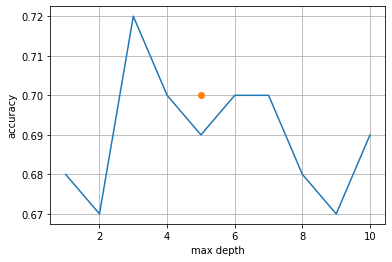

In [122]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 11))

# List to store the accuracy for each value of max_depth:
accuracy = []

for depth in max_depth_range:
  clf = tree.DecisionTreeClassifier(max_depth = depth, random_state=109)
  clf.fit(X_train, y_train)
  score = round(clf.score(X_test, y_test),2)
  accuracy.append(score)

plt.plot(max_depth_range, accuracy) #adds the line
plt.plot(5, 0.7, marker='o') #adds the point
plt.grid() #adds a grid to the plot
plt.ylabel('accuracy') #xlabel
plt.xlabel('max depth') #ylabel

print(accuracy)

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(clf.feature_importances_,2)})
importances = importances.sort_values('importance',ascending=False)

print(importances)


In [123]:
clf = tree.DecisionTreeClassifier(random_state=109) 

path = clf.cost_complexity_pruning_path(X_train, y_train) # determine values for alpha
ccp_alphas = path.ccp_alphas # extract diff values for alpha
ccp_alphas = ccp_alphas[:-1] # exclude max value for alpha (don't just want root node)

clf_dts = [] # array to put DT into

# Create a DT per value for alpha and store it in array
for ccp_alpha in ccp_alphas:
  clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  clf.fit(X_train, y_train)
  clf_dts.append(clf)

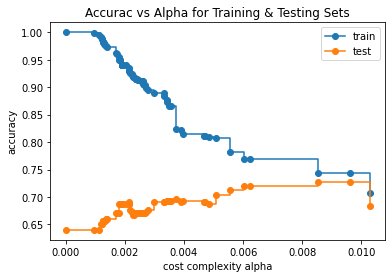

In [124]:


train_scores = [clf.score(X_train, y_train) for clf in clf_dts]
test_scores = [clf.score(X_test, y_test) for clf in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("cost complexity alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accurac vs Alpha for Training & Testing Sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

#0.013 - ccp

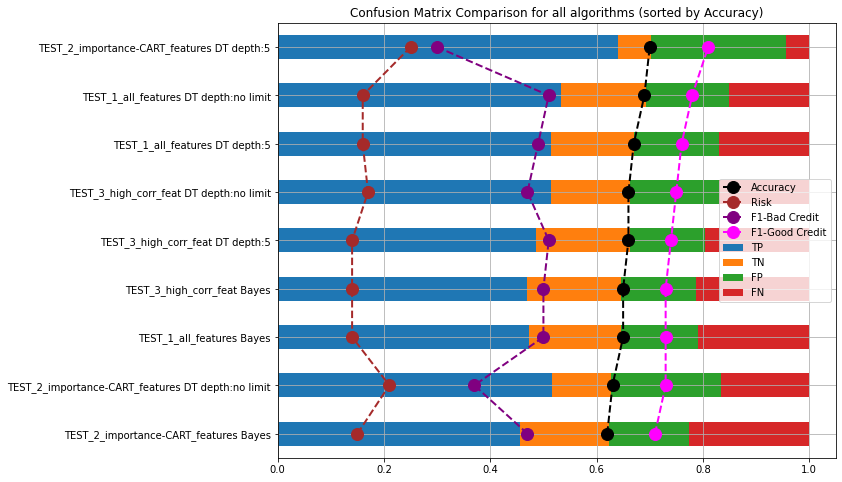

In [29]:
# plot confusion matrix bar chart for all the algorithms
ax = TestResults[["TP","TN","FP","FN"]].div(TestResults[["TP","TN","FP","FN"]].sum(axis=1),axis=0).plot.barh(
    figsize=(10,8),
    grid = True,
    ylim = (0,1), 
    stacked = True,
    title = "Confusion Matrix Comparison for all algorithms (sorted by Accuracy)",
    #color = ("azure","lightblue","salmon","red")
)
ax.plot(
    TestResults["accuracy"], 
    TestResults.index , 
    label='Accuracy',
    color='black', 
    marker='o', 
    linestyle='dashed',
    linewidth=2, 
    markersize=12)
ax.plot(
    TestResults["risk"], 
    TestResults.index , 
    label='Risk',
    color='brown', 
    marker='o', 
    linestyle='dashed',
    linewidth=2, 
    markersize=12)
ax.plot(
    TestResults["f1-score(0)"], 
    TestResults.index , 
    label='F1-Bad Credit',
    color='purple', 
    marker='o', 
    linestyle='dashed',
    linewidth=2, 
    markersize=12)
ax.plot(
    TestResults["f1-score(1)"], 
    TestResults.index , 
    label='F1-Good Credit',
    color='magenta', 
    marker='o', 
    linestyle='dashed',
    linewidth=2, 
    markersize=12)
ax.legend(loc = 'best')


In [30]:
print("Risk median =", round(TestResults["risk"].median(),2))
TestResultsLowRisk = TestResults[TestResults["risk"] <= TestResults["risk"].median()].copy()
print(TestResultsLowRisk.index)
TestResultsLowRisk.sort_values("accuracy",ascending=False)

Risk median = 0.16
Index(['TEST_2_importance-CART_features Bayes', 'TEST_1_all_features Bayes',
       'TEST_3_high_corr_feat Bayes', 'TEST_3_high_corr_feat DT depth:5',
       'TEST_1_all_features DT depth:5',
       'TEST_1_all_features DT depth:no limit'],
      dtype='object')


,TP,FP,TN,FN,precision(0),precision(1),recall(0),recall(1),f1-score(0),f1-score(1),accuracy,risk
TEST_1_all_features DT depth:no limit,160,47,48,45,0.52,0.77,0.51,0.78,0.51,0.78,0.69,0.16
TEST_1_all_features DT depth:5,154,48,47,51,0.48,0.76,0.49,0.75,0.49,0.76,0.67,0.16
TEST_3_high_corr_feat DT depth:5,146,42,53,59,0.47,0.78,0.56,0.71,0.51,0.74,0.66,0.14
TEST_1_all_features Bayes,142,43,52,63,0.45,0.77,0.55,0.69,0.50,0.73,0.65,0.14
TEST_3_high_corr_feat Bayes,141,42,53,64,0.45,0.77,0.56,0.69,0.50,0.73,0.65,0.14
TEST_2_importance-CART_features Bayes,137,45,50,68,0.42,0.75,0.53,0.67,0.47,0.71,0.62,0.15


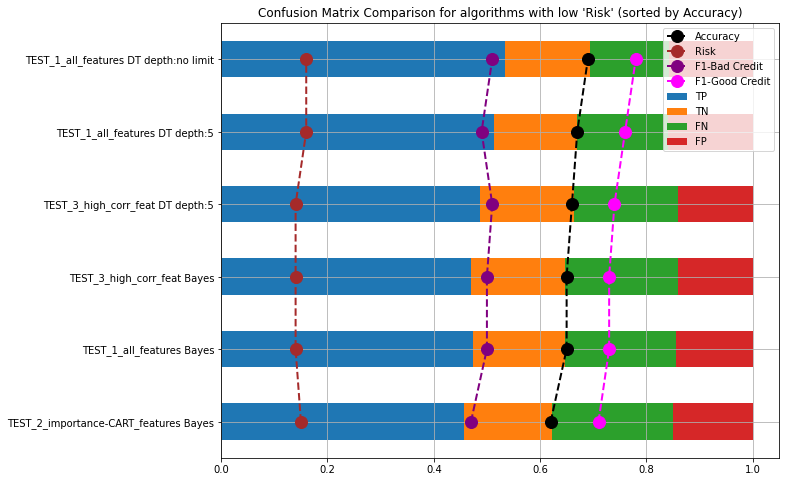

In [31]:
# plot confusion matrix bar chart for all the algorithms
ax = TestResultsLowRisk[["TP","TN","FN","FP"]].div(TestResultsLowRisk[["TP","TN","FP","FN"]].sum(axis=1),axis=0).plot.barh(
    figsize=(10,8),
    grid = True,
    ylim = (0,1), 
    stacked = True,
    title = "Confusion Matrix Comparison for algorithms with low 'Risk' (sorted by Accuracy)"
)
ax.plot(
    TestResultsLowRisk["accuracy"], 
    TestResultsLowRisk.index , 
    label='Accuracy',
    color='black', 
    marker='o', 
    linestyle='dashed',
    linewidth=2, 
    markersize=12
)
ax.plot(
    TestResultsLowRisk["risk"], 
    TestResultsLowRisk.index , 
    label='Risk',
    color='brown', 
    marker='o', 
    linestyle='dashed',
    linewidth=2, 
    markersize=12
)
ax.plot(
    TestResultsLowRisk["f1-score(0)"], 
    TestResultsLowRisk.index , 
    label='F1-Bad Credit',
    color='purple', 
    marker='o', 
    linestyle='dashed',
    linewidth=2, 
    markersize=12)
ax.plot(
    TestResultsLowRisk["f1-score(1)"], 
    TestResultsLowRisk.index , 
    label='F1-Good Credit',
    color='magenta', 
    marker='o', 
    linestyle='dashed',
    linewidth=2, 
    markersize=12)
ax.legend(loc = 'best')


In [119]:
# Decision Tree Graphs
from IPython.display import Image, display
            
for k,graph in graphs.items():
    print(k)
    imagefile = graph.render(filename=k, format="png", cleanup=True)
    display(Image(filename=imagefile))

Output hidden; open in https://colab.research.google.com to view.